<a href="https://colab.research.google.com/github/MariaPetrovskaya/Natural-Language-Processing/blob/main/Classification%20of%20Text%20Complexity%20W2V%20and%20TensorFlow/Vers2_Classification_of_EnglishText_Complexity_Word2Vec_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About project

###Introduction

*   Watching films in the original language is a popular and effective method  for training languages skills.
*   It is important to choose a film that suits actual level of difficulty, (possible to understood 50-70% of the dialogues).
*   To fulfill this condition, the expert must watch the new film and decide what level it corresponds to. However, this requires a lot of time.


###Business task

*   Customer of this product: the foreign language courses.
*   Develop an ML solution (multi-class classification) for prediction of difficulty levels for English-language films.









###Initial data
*   The study was experimental stage, dataset was of limited size (200 + records).
*   Subtitles of films saved in directories with names as level of difficulty according to the CEFR ([Common European Framework of Reference]('https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D1%89%D0%B5%D0%B5%D0%B2%D1%80%D0%BE%D0%BF%D0%B5%D0%B9%D1%81%D0%BA%D0%B8%D0%B5_%D0%BA%D0%BE%D0%BC%D0%BF%D0%B5%D1%82%D0%B5%D0%BD%D1%86%D0%B8%D0%B8_%D0%B2%D0%BB%D0%B0%D0%B4%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B8%D0%BD%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%BD%D1%8B%D0%BC_%D1%8F%D0%B7%D1%8B%D0%BA%D0%BE%D0%BC' 'wikipedia')).
*   Movie subtitles in XLSX files containing the name of the movies and the degree of difficulty according to the CEFR scale.






---



In [ ]:
# ! pip install gensim # better to install this library first, if work in colab

In [ ]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
import multiprocessing

from gensim.models import Word2Vec

In [ ]:
from gensim import models

In [ ]:
from gensim.utils import keep_vocab_item, call_on_class_only, deprecated
from gensim.models.keyedvectors import KeyedVectors, pseudorandom_weak_vector
from gensim import utils, matutils

# This import is required by pickle to load models stored by Gensim < 4.0, such as Gensim 3.8.3.
from gensim.models.keyedvectors import Vocab  # noqa

In [ ]:
# %%capture
# # need to install in colab
# !pip install pysrt

# !pip install tabula-py


In [ ]:
import tensorflow as tf

In [ ]:
from string import punctuation

from collections import Counter
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

In [ ]:
# imports
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,
                                     StratifiedShuffleSplit,
                                     GridSearchCV
                                     )


from sklearn.metrics import (classification_report,
                             f1_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay
                             )

from sklearn.base import (BaseEstimator,
                          TransformerMixin
                          )
import pickle
import pysrt

import requests
import urllib
import json
import zipfile
from zipfile import ZipFile
import tabula
from tabula import read_pdf


# Data Loading and Preprocessing



###Loadind data with movies

In [ ]:
#import from с Google Disk to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/datasets'
path_to_zip_file = f'{PATH}/English_scores.zip'
path_to_zip_file

'/content/drive/MyDrive/datasets/English_scores.zip'

In [ ]:
with ZipFile(path_to_zip_file, 'r') as zObject:
  znm = zObject.namelist()

In [ ]:
with ZipFile(path_to_zip_file, 'r') as zObject:
  movies_labels = zObject.extract('movies_labels.xlsx')

In [ ]:
#loading dataset with movies levels
df = pd.read_excel(movies_labels, index_col='id')
df.info

<bound method DataFrame.info of                                 Movie   Level
id                                           
0           10_Cloverfield_lane(2016)      B1
1    10_things_I_hate_about_you(1999)      B1
2                A_knights_tale(2001)      B2
3                A_star_is_born(2018)      B2
4                       Aladdin(1992)  A2/A2+
..                                ...     ...
236                     Matilda(2022)      C1
237                      Bullet train      B1
238            Thor: love and thunder      B2
239                         Lightyear      B2
240                        The Grinch      B1

[241 rows x 2 columns]>

In [ ]:
# looking list of levels
df['Level'].unique()

array(['B1', 'B2', 'A2/A2+', 'C1', 'B1, B2', 'A2/A2+, B1', 'A2'],
      dtype=object)

In [ ]:
# assign a numeric values to the levels
label_dict = {'A2': 1,
              'A2/A2+': 1,
              'B1': 2,
              'A2/A2+, B1': 2,
              'B2': 3,
              'B1, B2': 3,
              'C1': 4}
# change levels to numeric values
df['Level'] = df['Level'].replace(label_dict)

In [ ]:
# drop duplicates
df = df.drop_duplicates()
df.shape

(238, 2)

###Loading subtitles

In [ ]:
films_name = {}
for srt in znm:
  if srt.find('.srt') != -1 and srt.find('__MACOSX') == -1:
    films_name[srt.split('/')[-1]] = srt
print(len(films_name))

278


In [ ]:
# checking number of films from table with subtitles
films_filtr = set(films_name.keys()) & set(df['Movie'] + '.srt')
len(films_filtr)

229

In [ ]:
def load_subs(film):
  """loading subtitles function"""
  fsrt = f'{film}.srt'
  if fsrt not in set(films_name.keys()):
    return None
  with ZipFile(path_to_zip_file, 'r') as zObject:
    f = zObject.extract(films_name[fsrt])
    try:
      subs = pysrt.open(f)
    except:
      subs = pysrt.open(f,encoding='iso-8859-1')
  return subs

In [ ]:
%%time
#loading subtitles
df['subs'] = df['Movie'].apply(load_subs)

CPU times: user 11.2 s, sys: 383 ms, total: 11.5 s
Wall time: 16.5 s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df['subs']

In [ ]:
#dropping gaps
df = df.dropna().reset_index(drop=True)

In [ ]:
df

,Movie,Level,subs
0,10_Cloverfield_lane(2016),2,"[1\n00:00:55,279 --> 00:01:07,279\n<font color..."
1,10_things_I_hate_about_you(1999),2,"[1\n00:01:54,281 --> 00:01:55,698\nHey!\n, 2\n..."
2,A_knights_tale(2001),3,"[1\n00:00:15,089 --> 00:00:21,229\nResync: Xen..."
3,A_star_is_born(2018),3,"[1\n00:00:17,610 --> 00:00:22,610\n- <i><font ..."
4,Aladdin(1992),1,"[1\n00:00:27,240 --> 00:00:30,879\n<i>Oh, I co..."
...,...,...,...
225,Suits.S03E06.720p.HDTV.x264-mSD,4,"[1\n00:00:01,383 --> 00:00:02,751\nI lost Ava ..."
226,Suits.S03E07.HDTV.x264-mSD,4,"[1\n00:00:00,052 --> 00:00:01,352\nPreviously ..."
227,Suits.S03E08.480p.HDTV.x264-mSD,4,"[1\n00:00:01,436 --> 00:00:03,028\nI get Ava H..."
228,Suits.S03E09.480p.HDTV.x264-mSD,4,"[1\n00:00:00,024 --> 00:00:01,478\nPreviously ..."


###Data imbalances

In [ ]:
df['Level'].value_counts()

Level
3    105
2     55
4     39
1     31
Name: count, dtype: int64

##Classification task


###Subtitle text preprocessing

In [ ]:
# import re
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

При рассмотрении текстов после лемматизации были обнаружены лишние токены (например _x000В_), поэтому добавляется дополнительная функция обработки текста с помощью регулярных выражений.

In [ ]:
# set regular expressions for text preprocessing
HTML = r'<.*?>' # html tags
#TAG = r'{.*?}' # change tags to spaces
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]' # comments in parentheses
LETTERS = r'[^\w\s]' # anything that isn't a letter
SPACES = r'([ ])\1+' # repeated spaces
DOTS = r'[\.]+' # punctuation mark ellipsis
SYMB = r"[^\w\d'\s]" # punctuation marks other than apostrophe
def clean_subs(subs):
  """subtitle text preprocessing"""
  subs = subs[1:] # remove the first promotional subtitle
  txt = re.sub(HTML, ' ', subs.text) # html tags change to spaces
  # txt = re.sub(COMMENTS, ' ', txt) # comments in parentheses change to spaces
  # txt = re.sub(LETTERS, ' ', txt) # anything that isn't a letter is a space
  # txt = re.sub(DOTS, r'.', txt) # punctuation mark ellipsis change to dots
  # txt = re.sub(SPACES, r'\1', txt) # repeated spaces change to one space
  # txt = re.sub(SYMB, '', txt) # punctuation marks other than apostrophe change to an empty string
  # txt = re.sub('www', '', txt) # 'www' change to an empty string
  # txt = txt.lstrip().rstrip().replace("\n","") # left space trimming
  # txt = txt.encode('ascii', 'ignore').decode() # remove all non-ascii characters
  #txt = txt.lower() # to lowercase
  txt = ' '.join(txt.split())
  return txt

In [ ]:
df

In [ ]:
df['Level'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 230 entries, 0 to 229
Series name: Level
Non-Null Count  Dtype
--------------  -----
230 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


In [ ]:
df['clean_text'] = df.subs.apply(clean_subs)

In [ ]:
df['norm_text'] = df.clean_text.apply(preprocess)

In [ ]:
df

### Word2Vec for embedding

Word vectors: will use **Word2Vec** to train word embeddings, using **gensim**,   NLP library that features many vector-based models incuding word2vec.

The input must be a tokenized text

In [ ]:
all_text = ' '.join(df['clean_text'])

In [ ]:
all_text

In [ ]:
texts = [preprocess(text) for text in df['clean_text']]

In [ ]:
texts

In [ ]:
gensim.__version__

'4.3.2'

It is necessary to transfer the corpus for training to model; for other parameters there are default values.

In [ ]:
%%time
w2v = gensim.models.Word2Vec(texts, )

CPU times: user 20.5 s, sys: 134 ms, total: 20.6 s
Wall time: 13.4 s


To check the model work

In [ ]:
w2v.wv.most_similar('future')

[('marriage', 0.752711832523346),
 ('body', 0.7490952610969543),
 ('career', 0.7403905987739563),
 ('spark', 0.740052342414856),
 ('secretary', 0.737733781337738),
 ('diary', 0.7268183827400208),
 ('strength', 0.7214212417602539),
 ('gut', 0.7169687747955322),
 ('pocket', 0.7049973607063293),
 ('clan', 0.6966613531112671)]

In [ ]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300,
                             min_count=30,
                             max_vocab_size=10000,
                             window=5,
                             epochs=7)

CPU times: user 36 s, sys: 299 ms, total: 36.3 s
Wall time: 23.2 s


In [ ]:
w2v.wv.most_similar('future')

[('career', 0.5777560472488403),
 ('marriage', 0.5529298186302185),
 ('thoughts', 0.5378314256668091),
 ('beyond', 0.5338180065155029),
 ('freedom', 0.5316739678382874),
 ('ability', 0.5224693417549133),
 ('minds', 0.512201726436615),
 ('memory', 0.509645938873291),
 ('family', 0.5082769989967346),
 ('opinion', 0.5069559812545776)]

At next step we collect the dictionary

In [ ]:
vocab = Counter()

for text in df['norm_text']:
    vocab.update(text)

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

10561

In [ ]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

Next step is to set indexes for tokens

In [ ]:
X = []

for tokens in df['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

###Splitting data into training and test samples

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = df.Level.values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

###TensorFlow model

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
# embedding layer returns a sequence of vectors
# in this task we need to classify all text at once
# for this will get mean of single vectors as 1 text vector
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
# mean vector, fully connected layer, return the class probability
outputs = tf.keras.layers.Dense(5, activation='softmax')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=10)

In this model, vector representations are training from scratch.  To make it better, we can add pretrained vectors from word2vec to the embedding layer

In [ ]:
%%time
ft = gensim.models.Word2Vec(texts + df['norm_text'].values.tolist(), window=10, epochs=200) #epochs=1000 same result

CPU times: user 31min 36s, sys: 10.6 s, total: 31min 46s
Wall time: 19min 18s


Forming the matrix with vectors. The indices of the rows in this matrix are similar with the indices of the words in the dictionary.

In [ ]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # padding vector as zero
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]


    except KeyError:
        # for words that are not in the models, set some random vector
        continue
        weights[i] = ft.wv['rwwatandomhm']

In [ ]:
inputs = tf.keras.layers.Input(shape=(100,))

# enter matrix to the embedding layer
# set trainable=False, so that vectors don’t learn
# Note: if this is not done, embedding will learn again

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100,
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(5, activation='softmax')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='SparseCategoricalCrossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


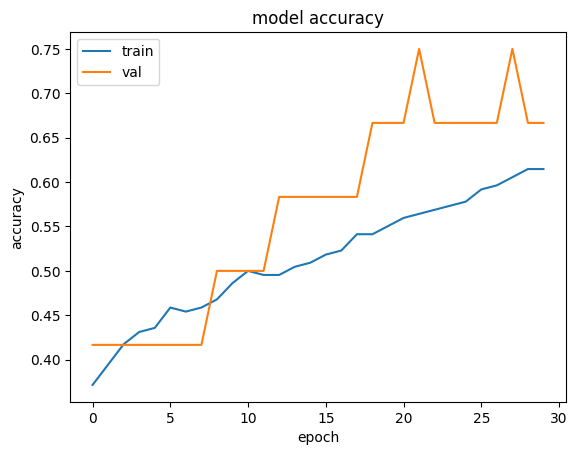

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['sparse_categorical_accuracy'])
plt.plot(model.history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The resulting metric sparse_categorical_accuracy = 0,75 is not bad for a small experimental dataset (230 items)

#Summary results

#### Conclusions
- The project is completed.
- Data was loaded and unpacked.
- Text data was preprocessed by .re (Regular expression operations).
- Word2Vec embeddings were trained using gensim library.
- A solution with TensorFlow has been implemented  ( using pretrained Word2Vec embeddings and also without them).
- The sparse_categorical_accuracy metric on validation was 0,75.
- To build a model with better metrics and practical application, a larger dataset is desirable.  

